# Check that current differential equation agrees with stress function

Generate data in usual way, calculate full library, determine coeffs, assess correctness of equation at each data point.

### Data Gen

In [1]:
import numpy as np
from scipy.integrate import quad
import sympy as sym
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import sys

sys.path.append('../')
sys.path.append('../src')
import data.Generation.VE_DataGen_Functions as vedg
from deepymod_torch.VE_params import coeffs_from_model_params, model_params_from_coeffs

In [2]:
def stress(w=1):
    sigma = lambda t: np.sin(w*t)/(w*t)
    dsigma = lambda t: (1/t)*(np.cos(w*t) - np.sin(w*t)/(w*t))
    
    return (sigma, dsigma)

In [3]:
def creep(elastic_moduli, viscosities):
    E = np.array(elastic_moduli).reshape(-1, 1)
    tau = np.array(viscosities).reshape(-1, 1) / E[1:, :]
    
    J = lambda t: 1/ E[0, :] + np.sum((1 - np.exp(- t / tau)) / E[1:, :])
    
    return J

In [4]:
def calculate_strain_single_t(stress_funcs, creep_func, dt, time_array):
    dt = np.array(dt).reshape(1)
    sigma, dsigma = stress_funcs
    integrand = lambda t_p: creep_func(dt - t_p) * dsigma(t_p)
    strain_single_t = sigma(time_array[0]) * creep_func(dt) + quad(integrand, time_array[0], dt)[0]
    return strain_single_t

In [5]:
def calculate_strain(time_array, E_mods, viscs, freq=1):    
    stress_funcs = stress(w=freq)
    creep_func = creep(E_mods, viscs)
    strain = np.array([calculate_strain_single_t(stress_funcs, creep_func, dt, time_array) for dt in time_array])
    return strain

In [6]:
time_array = np.linspace(0.001,40,500)
E_mods = [6, 1]
viscs = [15]
omega = 0.5

In [7]:
strain_array = calculate_strain(time_array, E_mods, viscs, freq=omega).flatten()

In [8]:
stress_lambda, _ = stress(w=omega)
stress_array = stress_lambda(time_array)
stress_array.shape

(500,)

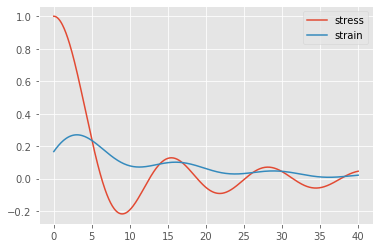

In [9]:
plt.plot(time_array, stress_array, label='stress')
plt.plot(time_array, strain_array, label='strain')
plt.legend()

### Calculate library

In [10]:
def num_derivs(dependent_data, independent_data, diff_order):
    
    data_derivs = dependent_data.copy()
    data_derivs = data_derivs.reshape(-1, 1)
    for _ in range(diff_order):
        data_derivs = np.append(data_derivs, np.gradient(data_derivs[:, -1].flatten(), independent_data.flatten()).reshape(-1,1), axis=1)
    
    return data_derivs

In [11]:
diff_order = len(viscs)

strain_theta = num_derivs(strain_array, time_array, diff_order)
stress_theta = num_derivs(stress_array, time_array, diff_order)
num_theta = np.append(strain_theta, stress_theta, axis=1)
num_theta.shape

(500, 4)

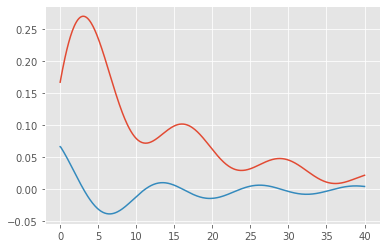

In [12]:
for idx in np.arange(strain_theta.shape[1]):
    plt.plot(time_array, strain_theta[:, idx])

#plt.ylim([-0.3, 0.3])

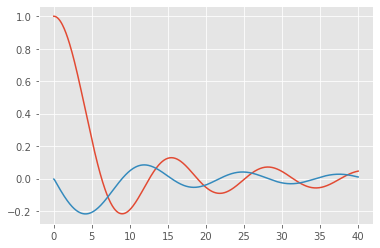

In [13]:
for idx in np.arange(stress_theta.shape[1]):
    plt.plot(time_array, stress_theta[:, idx])

#plt.ylim([-2, 2])

### Calculate coeffs

In [14]:
not_floats = coeffs_from_model_params(E_mods, viscs, print_expressions=True)
not_floats

[E_1/eta_1, (E_0 + E_1)/(E_0*eta_1), 1/E_0]


[1/15, 7/90, 1/6]

In [15]:
coeffs_strain_array = np.array([not_floats[0]] + [1] + not_floats[1:diff_order])
coeffs_stress_array = np.array(not_floats[diff_order:])
coeffs_array = np.concatenate((-coeffs_strain_array, coeffs_stress_array)).reshape(-1,1)
# negatives added to imitate transfer of LHS of equation to RHS.
print(coeffs_array.shape)
coeffs_array

(4, 1)


array([[-1/15],
       [-1],
       [7/90],
       [1/6]], dtype=object)

### Assess correctness

In [16]:
equation_residuals = num_theta @ coeffs_array
equation_residuals.shape

(500, 1)

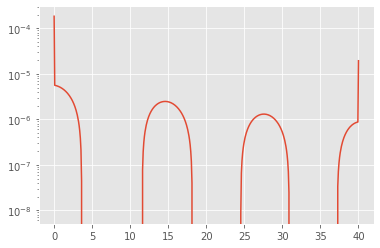

In [17]:
plt.semilogy(time_array, equation_residuals.flatten())

# DeepMoD

In [18]:
sys.path.append('../src')
from deepymod_torch.library_function import stress_input_library
from deepymod_torch.DeepMod import DeepMoD, Not_DeepMoD
from deepymod_torch.VE_params import coeffs_from_model_params, model_params_from_coeffs

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [19]:
import torch

In [20]:
Input_Type = 'Stress'
Input_Function = lambda time_data: torch.sin(omega * time_data)/(omega * time_data)

In [21]:
time_Tensor = torch.tensor(time_array.reshape((-1,1)), dtype=torch.float32, requires_grad=True)
Strain_Tensor = torch.tensor(strain_array.reshape((-1,1)), dtype=torch.float32)

In [22]:
optim_config = {'lambda': 10**-5, 'max_iterations': 30001}

In [23]:
network_config = {'input_dim': 1, 'hidden_dim': 40, 'layers': 3, 'output_dim': 1}

In [24]:
lib_config = {'type': stress_input_library, 'diff_order': 2, 'coeff_sign': 'positive', 'input_type': Input_Type, 'input_expr': Input_Function}

In [25]:
not_floats = coeffs_from_model_params(E_mods, viscs)
[float(x) for x in not_floats]

[0.06666666666666667, 0.07777777777777778, 0.16666666666666666]

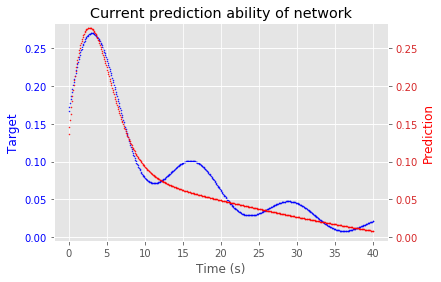

Epoch | Total loss | MSE | PI | L1 
800 7.0E-04 2.7E-04 3.6E-04 7.2E-05
tensor([[0.4475],
        [1.5214],
        [0.1736],
        [0.0241],
        [0.9632]], requires_grad=True)
lrs are 0.001 0.001
Time elapsed: 0.0 minutes 37.93915247917175 seconds


KeyboardInterrupt: 

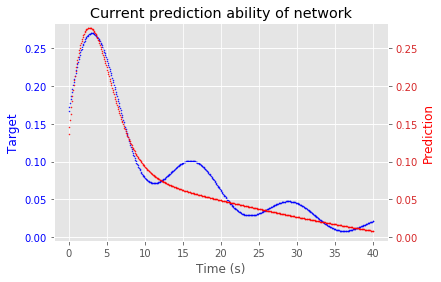

In [26]:
sparse_coeff_vector, sparsity_mask, network = DeepMoD(time_Tensor, Strain_Tensor, network_config, lib_config, optim_config)

In [27]:
sparse_coeff_vector

[tensor([[0.3249],
         [0.0595],
         [0.3793],
         [0.1874]], requires_grad=True)]

In [28]:
sparsity_mask

[tensor([0, 1, 2, 3])]